# Finetuning pretrained model (Keras Core with JAX backend)

This notebook is a JAX-backend port of `sessions/finetuning.ipynb` using Keras Core (KERAS_BACKEND='jax'). It implements standard classification (softmax + categorical crossentropy) on the Hyena ID 2022 dataset.

Important: Activate the `DataSciPy` mamba environment before running the notebook:
```bash
mamba activate DataSciPy
```
The notebook uses a Keras `Sequence` to load and preprocess images as NumPy arrays so they work with the JAX backend. It will attempt to use `keras.applications.efficientnet_v2.EfficientNetV2S` for a pretrained backbone; if unavailable it falls back to a small ConvNet.

In [1]:
%matplotlib inline
import os
# Ensure Keras Core uses JAX backend. Set before importing keras.
os.environ.setdefault('KERAS_BACKEND', 'jax')
import json, tarfile, urllib.request, random
from pathlib import Path
from collections import Counter
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import keras
from keras import layers
print('Keras backend:', keras.backend.backend())
print('JAX version:', jax.__version__)
print('JAX devices:', jax.devices())

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='jax')

Keras backend: jax
JAX version: 0.7.0
JAX devices: [CpuDevice(id=0)]


In [2]:
# Download and extract dataset (same URL as original)
url = "http://us-west-2.opendata.source.coop.s3.amazonaws.com/agentmorris/lila-wildlife/wild-me/hyena.coco.tar.gz"
out_path = '../data/hyena.coco.tar.gz'
extract_dir = '../data/hyena'
os.makedirs(os.path.dirname(out_path), exist_ok=True)
if not os.path.exists(extract_dir):
    if not os.path.exists(out_path):
        print(f'Downloading {url} to {out_path}')
        urllib.request.urlretrieve(url, out_path)
    print('Extracting...')
    with tarfile.open(out_path, 'r:gz') as t:
        os.makedirs(extract_dir, exist_ok=True)
        t.extractall(path=extract_dir)
else:
    print('Data already extracted.')

Data already extracted.


In [3]:
# Parse COCO-like annotations (same as original notebook)
with open('../data/hyena/hyena.coco/annotations/instances_train2022.json','r') as f:
    metadata = json.load(f)
bboxes = {a['image_id']: a['bbox'] for a in metadata['annotations']}
img2name = {a['image_id']: a['name'] for a in metadata['annotations']}
img_ids = np.array(list(img2name.keys()))
counter = Counter(img2name.values())
name2id = {k:i for i,k in enumerate(counter.keys())}
int2name = {i:k for k,i in name2id.items()}
labels = np.array([name2id[img2name[img]] for img in img_ids])
n_classes = int(labels.max() + 1)
print('Number of classes:', n_classes)

Number of classes: 256


In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=23)
train_idx, val_idx = next(sss.split(img_ids, labels))
print('Train samples', len(train_idx), 'Val samples', len(val_idx))

Train samples 2793 Val samples 311


In [5]:
# Build lists of image paths, corresponding bboxes and labels
path_template = '../data/hyena/hyena.coco/images/train2022/{:012d}.jpg'
train_ids = img_ids[train_idx]
val_ids = img_ids[val_idx]
train_paths = [path_template.format(int(i)) for i in train_ids]
val_paths = [path_template.format(int(i)) for i in val_ids]
train_bboxes = np.array([ [int(v) for v in bboxes[int(i)]] for i in train_ids ], dtype=np.int32)
val_bboxes = np.array([ [int(v) for v in bboxes[int(i)]] for i in val_ids ], dtype=np.int32)
train_labels = labels[train_idx].astype(np.int32)
val_labels = labels[val_idx].astype(np.int32)
print(train_paths[:2], train_labels[:2])

['../data/hyena/hyena.coco/images/train2022/000000002116.jpg', '../data/hyena/hyena.coco/images/train2022/000000001886.jpg'] [191   1]


In [6]:
# Simple Keras Sequence to load cropped images as numpy arrays (works with JAX backend)
class HyenaSequence(keras.utils.Sequence):
    def __init__(self, paths, bboxes, labels, batch_size=32, img_size=224, shuffle=True, augment=False, **kwargs):
        super().__init__(**kwargs)
        self.paths = np.array(paths)
        self.bboxes = np.array(bboxes)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.augment = augment
        self.indices = np.arange(len(self.paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.paths) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_paths = self.paths[batch_idx]
        batch_bboxes = self.bboxes[batch_idx]
        batch_labels = self.labels[batch_idx]
        X = np.zeros((len(batch_paths), self.img_size, self.img_size, 3), dtype=np.float32)
        y = np.zeros((len(batch_paths), n_classes), dtype=np.float32)
        for i, (p, bb, lab) in enumerate(zip(batch_paths, batch_bboxes, batch_labels)):
            img = Image.open(p).convert('RGB')
            x0, y0, w, h = [int(v) for v in bb]
            img = img.crop((x0, y0, x0 + w, y0 + h))
            img = img.resize((self.img_size, self.img_size))
            arr = np.array(img).astype(np.float32) / 255.0
            if self.augment:
                if np.random.rand() < 0.5:
                    arr = np.fliplr(arr).copy()
            # normalize using ImageNet stats
            mean = np.array([0.485, 0.456, 0.406], dtype=np.float32)
            std = np.array([0.229, 0.224, 0.225], dtype=np.float32)
            arr = (arr - mean) / std
            X[i] = arr
            y[i, int(lab)] = 1.0
        return X, y

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

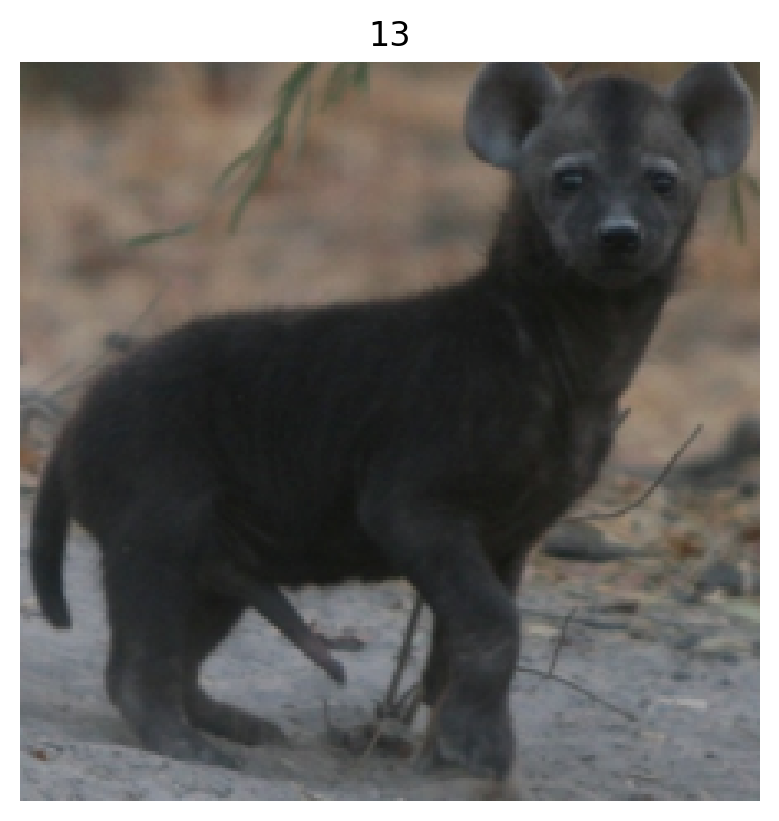

In [7]:
# Create sequences
img_size = 224
batch_size = 64
train_seq = HyenaSequence(train_paths, train_bboxes, train_labels, batch_size=batch_size, img_size=img_size, shuffle=True, augment=True)
val_seq = HyenaSequence(val_paths, val_bboxes, val_labels, batch_size=batch_size, img_size=img_size, shuffle=False, augment=False)
# quick visual check
X,y = train_seq[0]
plt.imshow(np.clip(X[0] * np.array([0.229,0.224,0.225]) + np.array([0.485,0.456,0.406]), 0, 1))
plt.title(str(np.argmax(y[0])))
plt.axis('off')

In [8]:
# Build model: use EfficientNetV2S from Keras applications
from keras.applications.efficientnet_v2 import EfficientNetV2S
print('Using EfficientNetV2S backbone from keras.applications')
backbone = EfficientNetV2S(
    include_top=False, 
    input_shape=(img_size, img_size, 3), 
    pooling='avg', 
    weights='imagenet'
)
backbone.trainable = False

img = keras.Input(shape=(img_size, img_size, 3))
x = backbone(img, training=False)
yhat = layers.Dense(n_classes, activation='softmax')(x)
model = keras.Model(img, yhat)
model.summary()

Using EfficientNetV2S backbone from keras.applications


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 1280)           │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,659,296 (78.81 MB)

 Trainable params: 327,936 (1.25 MB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_seq, 
    validation_data=val_seq, 
    epochs=5, 
    checkpoint='../data/finetune_keras_jax_initial.keras'
)

Epoch 1/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.0387 - loss: 5.3487 - val_accuracy: 0.0579 - val_loss: 5.0435 - learning_rate: 0.0010
Epoch 2/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 132s 3s/step - accuracy: 0.0813 - loss: 4.8883 - val_accuracy: 0.0772 - val_loss: 4.8249 - learning_rate: 0.0010
Epoch 3/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.0956 - loss: 4.6457 - val_accuracy: 0.0868 - val_loss: 4.6989 - learning_rate: 0.0010
Epoch 4/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 131s 3s/step - accuracy: 0.1128 - loss: 4.4653 - val_accuracy: 0.1190 - val_loss: 4.5929 - learning_rate: 0.0010
Epoch 5/5
44/44 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.1318 - loss: 4.3134 - val_accuracy: 0.1318 - val_loss: 4.5162 - learning_rate: 0.0010


In [21]:
# keras load model
model = keras.models.load_model('../data/finetune_keras_jax_initial.keras')

# Unfreeze backbone and fine-tune
backbone.trainable = True
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
)


In [22]:

callbacks = [
    keras.callbacks.ModelCheckpoint('../data/finetune_keras_jax_best.keras', save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=50, restore_best_weights=True),
]
history2 = model.fit(
    train_seq, 
    validation_data=val_seq, 
    epochs=300, 
    callbacks=callbacks
)

Epoch 1/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 135s 3s/step - accuracy: 0.1532 - loss: 4.1406 - val_accuracy: 0.1286 - val_loss: 4.5077 - learning_rate: 1.0000e-04
Epoch 2/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.1590 - loss: 4.1167 - val_accuracy: 0.1383 - val_loss: 4.4973 - learning_rate: 1.0000e-04
Epoch 3/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.1600 - loss: 4.1065 - val_accuracy: 0.1415 - val_loss: 4.4893 - learning_rate: 1.0000e-04
Epoch 4/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 128s 3s/step - accuracy: 0.1672 - loss: 4.0949 - val_accuracy: 0.1447 - val_loss: 4.4807 - learning_rate: 1.0000e-04
Epoch 5/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 129s 3s/step - accuracy: 0.1708 - loss: 4.0705 - val_accuracy: 0.1479 - val_loss: 4.4749 - learning_rate: 1.0000e-04
Epoch 6/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 0.1765 - loss: 4.0603 - val_accuracy: 0.1447 - val_loss: 4.4672 - learning_rate: 1.0000e-04
Epoch 7/300
44/44 ━━━━━━━━━━━━━━━━━━━━ 130s 3s/step - accuracy: 

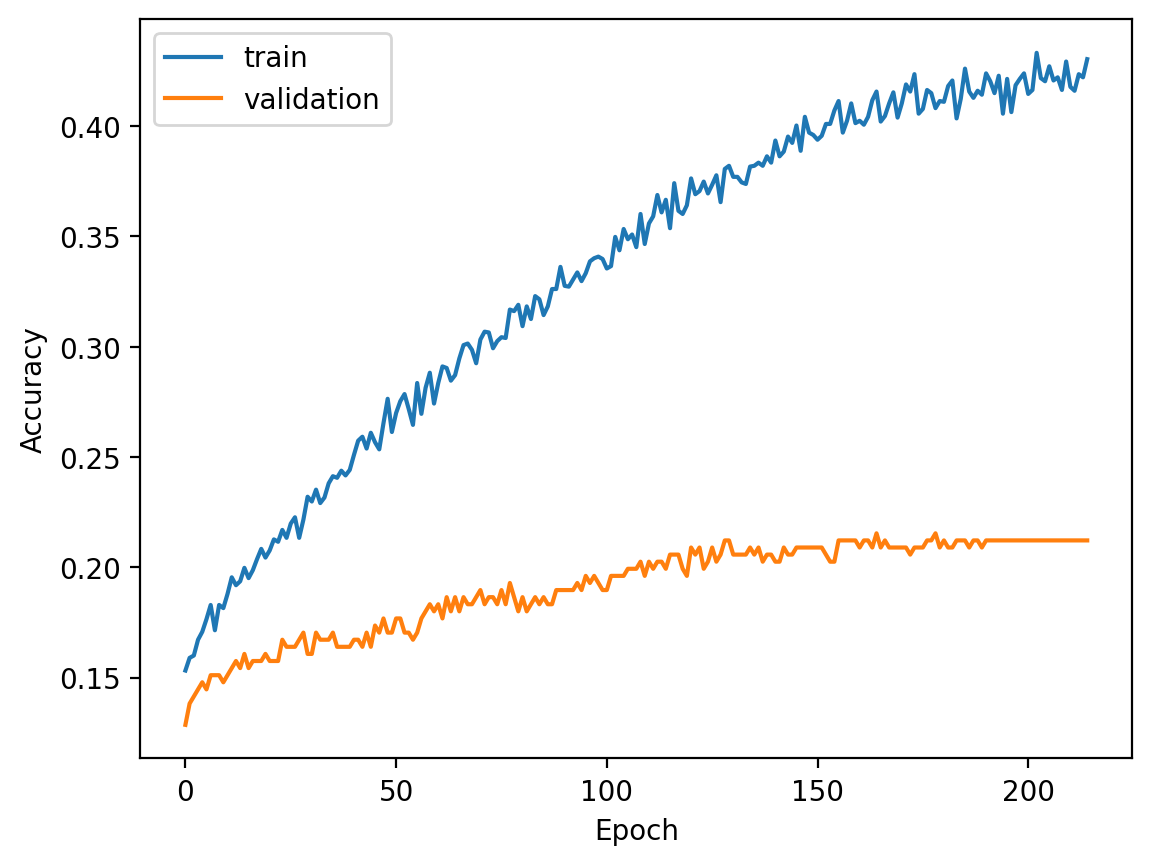

In [45]:
plt.plot(history2.history['accuracy'], label='train', )
plt.plot(history2.history['val_accuracy'], label='validation',)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend();

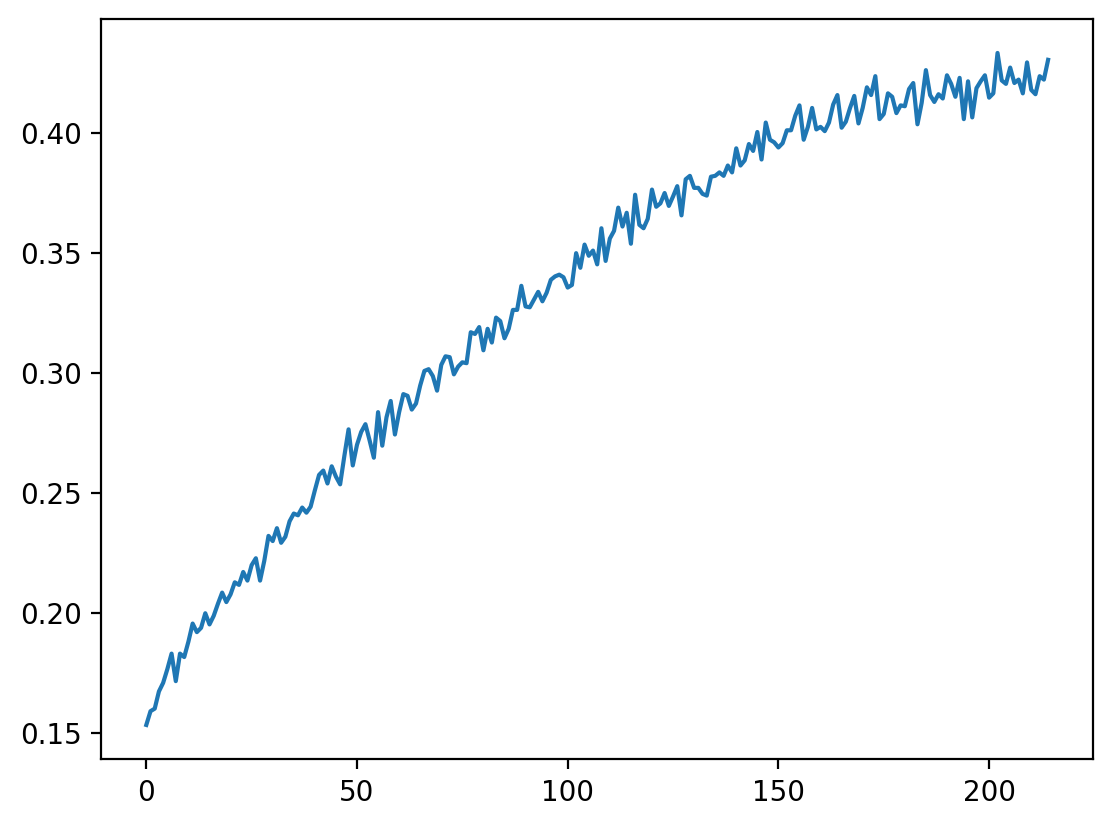

In [37]:
plt.plot(history2.history.get('accuracy'))